In [33]:
import netket as nk
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
Lx, Ly = 2,2          # number of honeycomb unit cells (total spins = 2*Lx*Ly)
J = 1.0
seed=1234

In [35]:
# Graph: Honeycomb with PBCs
g = nk.graph.Honeycomb(extent=(Lx, Ly), pbc=True)
hi = nk.hilbert.Spin(s=0.5, N=g.n_nodes,total_sz=0.0)
H = nk.operator.LocalOperator(hi)
for i, j in g.edges():  # nearest neighbors
        Sp_i = nk.operator.spin.sigmap(hi, i)
        Sm_i = nk.operator.spin.sigmam(hi, i)
        Sp_j = nk.operator.spin.sigmap(hi, j)
        Sm_j = nk.operator.spin.sigmam(hi, j)
        H += -(J/2.0) * (Sp_i @ Sm_j + Sm_i @ Sp_j)
print(H)

LocalOperator(dim=8, #acting_on=12 locations, constant=0.0, dtype=float64)


In [36]:
import scipy.sparse.linalg as sla
mat = H.to_sparse()  # sparse matrix in computational basis
evals = sla.eigsh(mat, k=4, which="SA", return_eigenvectors=False)
evals=np.sort(evals)
print("Lowest eigenvalues:", evals)
E_gs=evals[0]  # ground state energy from ED


Lowest eigenvalues: [-3.63027662 -2.13577921 -2.13577921 -2.13577921]


  0%|                                                   | 0/100 [00:00<?, ?it/s]


=== Results ===
Energy density  E/N = -0.45327415  ± 2.24e-04
<S^z_tot>      = 0.000000  ± nan


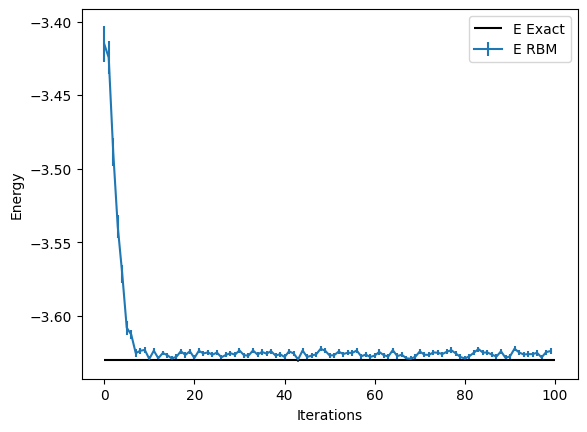

In [37]:
model = nk.models.RBM(alpha=2)
sampler = nk.sampler.MetropolisExchange(hilbert=hi, graph=g, n_chains=16)

vs = nk.vqs.MCState(
    sampler,
    model=model,
    n_samples=4096,             # total samples per iteration
    n_discard_per_chain=32,     # thermalization per chain
    seed=seed,
)

opt = nk.optimizer.Sgd(learning_rate=0.1)
sr = nk.optimizer.SR(diag_shift=0.1)   # stochastic reconfiguration
log = nk.logging.RuntimeLog()

driver = nk.VMC(hamiltonian=H, optimizer=opt, variational_state=vs, preconditioner=sr)
niters=100
driver.run(n_iter=niters, out=log)
from netket.operator.spin import sigmaz
Sz_tot = sum(0.5 * sigmaz(hi, i) for i in range(hi.size))

E = vs.expect(H)
Sz_val = vs.expect(Sz_tot)


print("\n=== Results ===")
print(f"Energy density  E/N = {E.mean.real/hi.size:.8f}  ± {E.error_of_mean/hi.size:.2e}")
print(f"<S^z_tot>      = {Sz_val.mean.real:.6f}  ± {Sz_val.error_of_mean:.2e}")

data_RBM = log.data
#print(data_RBM)


plt.errorbar(
    data_RBM["Energy"].iters,
    data_RBM["Energy"].Mean,
    yerr=data_RBM["Energy"].Sigma,
    label="E RBM",
)
plt.hlines([E_gs], xmin=0, xmax=niters, color="black", label="E Exact")
plt.legend()

plt.xlabel("Iterations")
plt.ylabel("Energy")
plt.show()
